In [1]:
from htke.load_data import *
from htke.process_ir_data import *
from htke.load_conditions import *
from htke.spka import *
from htke.rpka import *
pd.options.mode.chained_assignment = None  # default='warn' stops the slice error

### Go to directory

In [2]:
%pwd
%cd ir_data/GL-06-56-1

C:\Users\Paul Dingwall\Documents\github\htke\ir_data\GL-06-53-4


### Load Raw Data

<AxesSubplot:xlabel='Relative Time'>

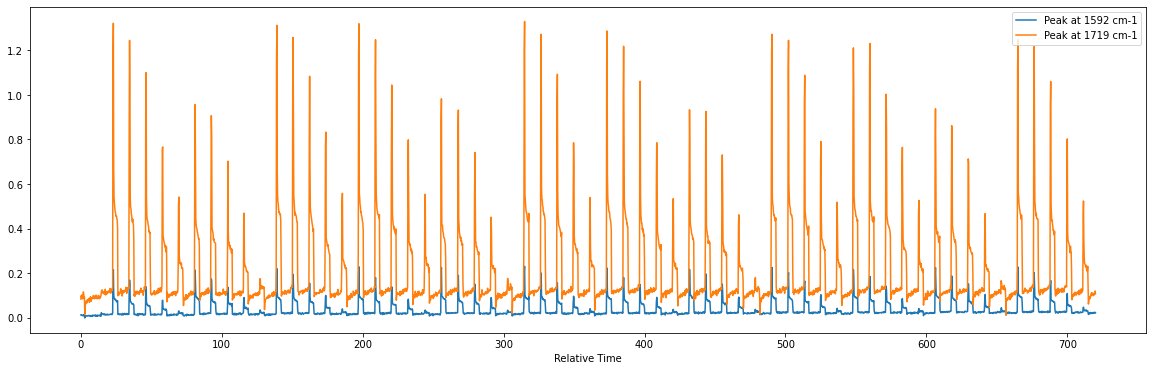

In [3]:
# Instantiate class
Data()

# Load data to dataframe
ir_data = Data.read()

# Visualise the data
Data.plot(ir_data)

#ir_data

### Find the Peaks in the Raw Data

In [4]:
# List all the wavelengths observed
print([col for col in ir_data.columns if 'Peak' in col])

['Peak at 1592 cm-1', 'Peak at 1719 cm-1']


In [5]:
# Choose peak
peak_of_interest = 'Peak at 1592 cm-1'

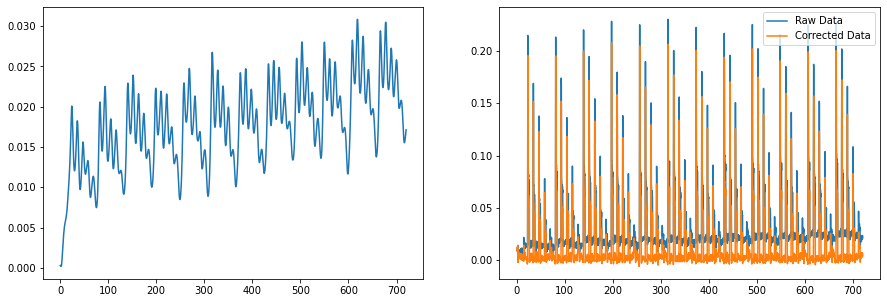

In [6]:
# Correct the baseline
correction = Data.baseline_correction(ir_data[peak_of_interest], peak_of_interest)
ir_data[peak_of_interest] = ir_data[peak_of_interest] - correction

# Plot it to see
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(15,5))
ax1.plot(ir_data['Relative Time'], correction)
ax2.plot(ir_data['Relative Time'], ir_data[peak_of_interest] + correction, label = 'Raw Data')
ax2.plot(ir_data['Relative Time'], ir_data[peak_of_interest], label = 'Corrected Data')
ax2.legend()

In [7]:
# Instantiate class
peaks = Peaks(ir_data)

# Auto find prominence and height to match number of conditions
prominence, no_reactions, points_per_reaction = peaks.auto_prom(peak_of_interest)
height = peaks.auto_height(peak_of_interest)
residence_time = peaks.auto_area(peak_of_interest, prominence, no_reactions, points_per_reaction)

print('There are', no_reactions, 'reactions with', points_per_reaction, 'points per reaction')
print('Prominence threshold =', np.round(prominence, 4))
print('Height threshold =', np.round(height, 4))
print('Residence time =', np.round(residence_time, 2))

There are 12 reactions with 5 points per reaction
Prominence threshold = 0.0164
Height threshold = 1.0
Residence time = 1.5


In [8]:
# Set some variables
time_adjust_before = -1
time_adjust_after = 4

# For loop to see all areas - Makes lots of plots, can take a while
# for var in range(0, no_reactions * points_per_reaction):
#     peaks.exp_area_sp(prominence, residence_time, peak_of_interest, time_adjust_before, time_adjust_after, var)
#     print(var)

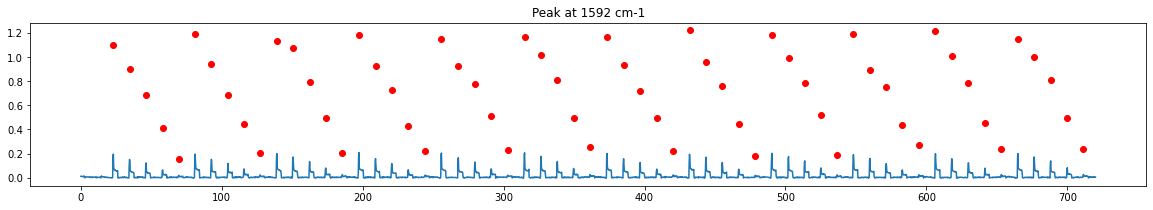

In [17]:
## PROMINENCE: Determine the peak prominences of a single wavelength
#processed_ir_data = peaks.prominence(prominence, peak_of_interest)

## EXP AREA: Determine the experimental areas of a single wavelength
processed_ir_data = peaks.exp_area(prominence, residence_time, peak_of_interest, time_adjust_before, time_adjust_after)

## Visualise which peaks have been picked - single peak
peaks.plot(processed_ir_data, peak_of_interest)

### Smooth the data

Average t0s and apply linear smoothing to experimental data

In [18]:
processed_ir_data = peaks.t0_correction(processed_ir_data, no_reactions, points_per_reaction)

processed_ir_data = peaks.linear_correction_fit_first(processed_ir_data, no_reactions, points_per_reaction)

#peaks.plot_corrections(processed_ir_data)

### Read experimental conditions and add to dataframe

In [19]:
Conditions()
experimental_data = Conditions.read(processed_ir_data)
#experimental_data

Inputs seem good: IR Datapoints =  60 , Number of conditions =  60


### Create the SPKA profiles

In [12]:
spka = SPKA(experimental_data)

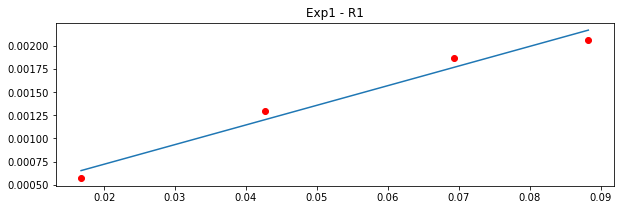

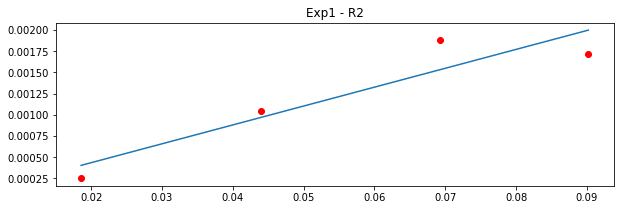

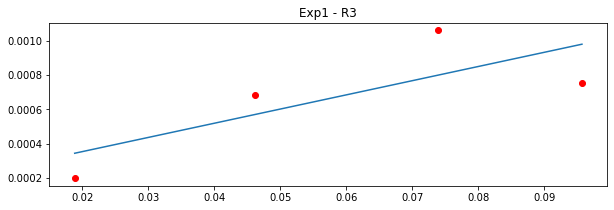

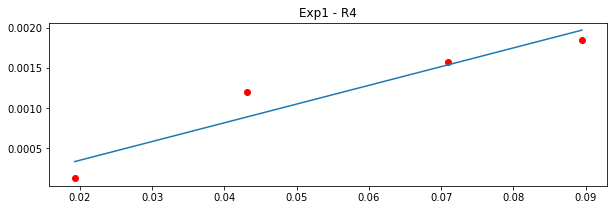

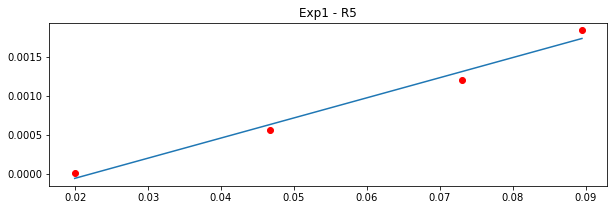

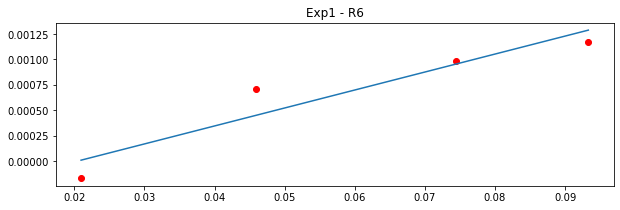

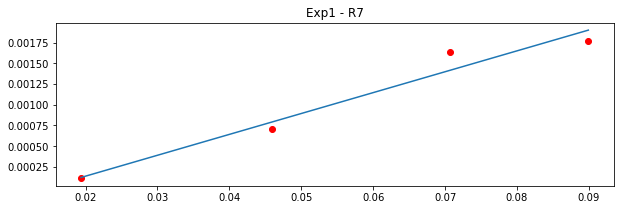

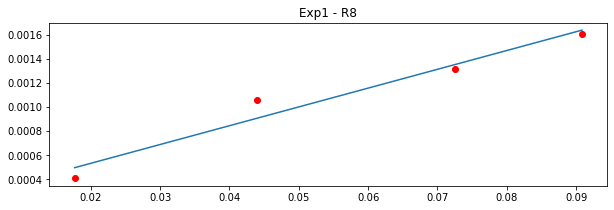

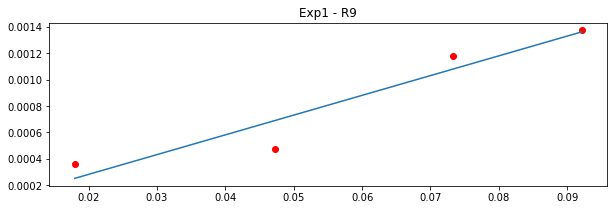

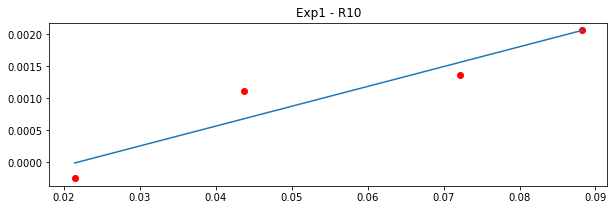

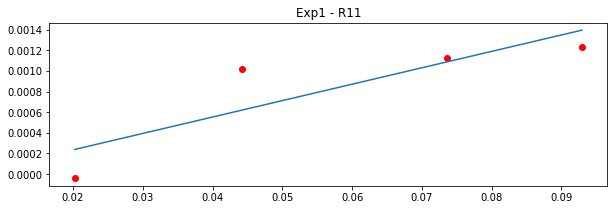

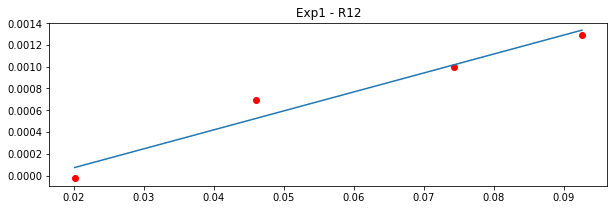

In [20]:
spka_data = spka.spka('[A]0')
spka.plot(spka_data)

In [14]:
spka_data = spka.spka_best_fit(spka_data)
#spka.plot(spka_data)

In [15]:
# Set up excelwriter
writer = pd.ExcelWriter(ir_data['Exp No'][0] + ' - ' +   # Adds experiment title - name of txt file
                        '.xlsx', engine='xlsxwriter')
workbook=writer.book

# Output data
#rpka_results.to_excel(writer, sheet_name='RPKA Data', startrow=0 , startcol=0, index=False)
spka_data.to_excel(writer, sheet_name='SPKA Data', startrow=0 , startcol=0, index=False)
ir_data.to_excel(writer, sheet_name='IR Data', startrow=0 , startcol=0, index=False)
processed_ir_data.to_excel(writer, sheet_name='Processed IR', startrow=0 , startcol=0, index=False)
experimental_data.to_excel(writer, sheet_name='Experimental Data', startrow=0 , startcol=0, index=False)
#conditions.to_excel(writer, sheet_name='Conditions', startrow=0 , startcol=0, index=False)

# Save
writer.save()

# This won't work if the excel file is open